In [38]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import json
import os

from dare import Riccati
from data_gen import generate_simulated_data
from device import device
from env_setup import *
from human import HumanRobotEnv
from models import ThetaEstimatorTransformer

In [39]:
# Generate trajectories to train estimator
sim_policy = dict()
sim_policy['human_state'] = 'varying'  # can be 'fixed' or 'varying'
sim_policy['mental_state'] = 'fixed'  # can be 'fixed' or 'varying'

# sim_policy['human_state_init'] = [[1.3], [0.3]]
# sim_policy['human_state_init'] = [[0.4], [0.0]] # only needed when human_state = 'fixed'
sim_policy['mental_state_init'] = [[1.0]] # only needed when mental_state = 'fixed'

sim_time = 20
n_demo = 100
is_updating_internal_model = True
stochastic_human = False
human_lr = 2.0

train_split = 0.7
train_size = int(n_demo * train_split)
test_size = n_demo - train_size

epochs = 100
model_lr = 0.01

data = generate_simulated_data(sim_policy, sim_time, n_demo, is_updating_internal_model, stochastic_human, human_lr)
robot_states, human_actions, human_obs, human_mental_states = data

robot_states_train, robot_states_test = robot_states[:train_size], robot_states[train_size:]
human_actions_train, human_actions_test = human_actions[:train_size], human_actions[train_size:]
human_obs_train, human_obs_test = human_obs[:train_size], human_obs[train_size:]
human_mental_states_train, human_mental_states_test = human_mental_states[:train_size], human_mental_states[train_size:]

100%|██████████| 100/100 [00:01<00:00, 77.06it/s]


### Visualize simulated human trajectories

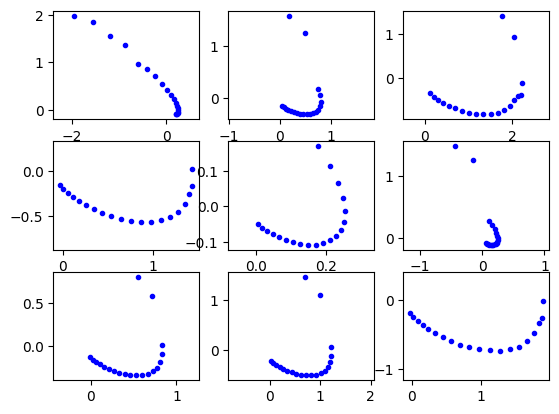

In [40]:
n = 2 if (n_demo < 9) else 3
fig, axs = plt.subplots(n, n)
for i in range(n):
    for j in range(n):
        ax = axs[i][j]
        idx = (i*n) + j
        human_traj = np.array(robot_states_train[idx]).squeeze()
        ax.plot(human_traj[:,0],human_traj[:,1],'bo', markersize=3)
        ax.axis(xmin=-1, xmax=1, ymin=-1, ymax=1)
        ax.axis('equal')

### Visualize simulated human internal models

[array([[1.]]), array([[0.41219417]]), array([[0.67851381]]), array([[0.17702633]]), array([[1.]]), array([[0.63563382]]), array([[0.44154685]]), array([[0.50511413]]), array([[0.49793885]]), array([[0.51053392]]), array([[0.52722028]]), array([[0.54802575]]), array([[0.57322321]]), array([[0.60293092]]), array([[0.63704705]]), array([[0.67525223]]), array([[0.717048]]), array([[0.76181335]]), array([[0.80886522]]), array([[0.85886522]])]
[array([[1.]]), array([[0.]]), array([[1.]]), array([[0.46453864]]), array([[0.50115531]]), array([[0.5249688]]), array([[0.55477038]]), array([[0.59122411]]), array([[0.63365484]]), array([[0.68058668]]), array([[0.73058668]]), array([[0.78058668]]), array([[0.83058668]]), array([[0.87584667]]), array([[0.91694879]]), array([[0.95351368]]), array([[0.98578652]]), array([[1.]]), array([[1.]]), array([[1.]])]
[array([[1.]]), array([[0.]]), array([[1.]]), array([[0.]]), array([[0.06599183]]), array([[0.34960269]]), array([[0.51827875]]), array([[0.52269

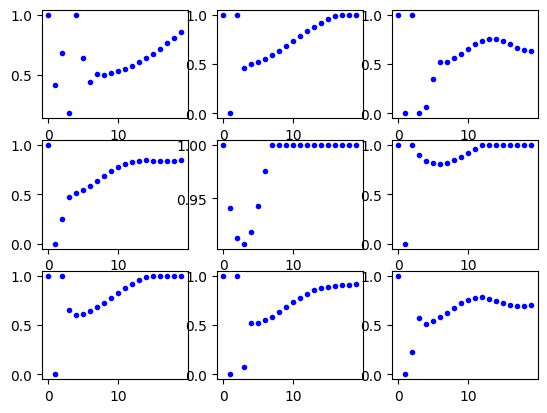

In [41]:
fig, axs = plt.subplots(n, n)
for i in range(n):
    for j in range(n):
        ax = axs[i][j]
        idx = (i*n) + j
        print(human_mental_states_train[idx])
        human_internal_state_traj = np.array(human_mental_states_train[idx]).squeeze()
        ax.plot(human_internal_state_traj, 'bo', markersize=3)

### Pre-processing trajectory data for estimator

In [42]:
states_train = torch.tensor(robot_states_train, device=device)
states_train = states_train.view(train_size * sim_time, nX)
states_test = torch.tensor(robot_states_test, device=device)
states_test = states_test.view(test_size * sim_time, nX)

actions_train = torch.tensor(human_actions_train, device=device)
actions_train = actions_train.view(train_size * sim_time, nU)
actions_test = torch.tensor(human_actions_test, device=device)
actions_test = actions_test.view(test_size * sim_time, nU)

obs_train = torch.tensor(human_obs_train, device=device)
obs_train = obs_train.view(train_size * sim_time, nX)
obs_test = torch.tensor(human_obs_test, device=device)
obs_test = obs_test.view(test_size * sim_time, nX)

inputs_train = torch.cat((states_train, actions_train, obs_train), axis=1)
inputs_train = inputs_train.view(train_size, sim_time, nX + nU + nX).double()
inputs_test = torch.cat((states_test, actions_test, obs_test), axis=1)
inputs_test = inputs_test.view(test_size, sim_time, nX + nU + nX).double()

print('Train:', inputs_train.shape)
print('Test:', inputs_test.shape)

Train: torch.Size([70, 20, 5])
Test: torch.Size([30, 20, 5])


### Train $\theta_H$ estimator E2E with LQR

In [43]:
transformer_estimator = ThetaEstimatorTransformer().to(device).double()
optimizer = torch.optim.Adam(transformer_estimator.parameters(), lr=model_lr)

In [44]:
def predict_action(state, theta_H):
    B_hat_tensor = theta_H * torch.tensor([[0., ],[1.0]], device = device).double()
    P_hat = Riccati.apply(A_tensor, B_hat_tensor, Q_tensor, R_tensor)

    K = torch.linalg.multi_dot((
        torch.linalg.pinv(torch.add(
            R_tensor,
            torch.linalg.multi_dot((torch.transpose(B_hat_tensor, 0, 1), P_hat, B_hat_tensor))
        )),
        torch.transpose(B_hat_tensor, 0, 1),
        P_hat,
        A_tensor
    ))
    action_pred = -torch.matmul(K, state)
    return action_pred

def forward_pass(model, inputs, curr_traj_idx):
    inputs = inputs.reshape(-1, inputs.shape[0], inputs.shape[1])
    theta_Hs = model(inputs)
    theta_Hs = theta_Hs.reshape(sim_time)
    theta_H_error = 0

    step_losses = []
    for i in range(sim_time - 1):
        # theta_H = theta_Hs[i] * 0.0 + human_mental_states[curr_traj_idx][i][0][0]
        theta_H = theta_Hs[i]
        theta_H_true = human_mental_states_train[curr_traj_idx][i][0][0]
        theta_H_error += torch.linalg.norm(theta_H - theta_H_true).data.item()

        input = inputs[0][i]
        state, action, obs = torch.split(input, [2, 1, 2])
        
        action_pred = predict_action(state, theta_H)
        # print(action_pred, action)

        loss_fn = nn.MSELoss()
        loss = loss_fn(action_pred, action)

        if abs(loss) > 20:
            ipdb.set_trace()

        step_losses.append(loss)
    
    return step_losses, theta_H_error

def train_epoch(model, inputs):
    model.train()
    all_losses = []
    theta_H_error_all = 0
    for idx in range(inputs.shape[0]):
        inp = inputs[idx]
        step_losses, theta_H_error = forward_pass(model, inp, idx)
        theta_H_error_all += theta_H_error
        all_losses += step_losses
    
    optimizer.zero_grad()
    total_loss = sum(all_losses) / (sim_time * inputs.shape[0])
    total_loss.backward()
    optimizer.step()

    theta_H_error_all /= (sim_time * inputs.shape[0])

    return total_loss.data.item(), theta_H_error_all

def test_epoch(model, inputs):
    model.eval()
    all_losses = []
    theta_H_error_all = 0
    for idx in range(inputs.shape[0]):
        inp = inputs[idx]
        step_losses, theta_H_error = forward_pass(model, inp, idx)
        theta_H_error_all += theta_H_error
        all_losses += step_losses
    
    total_loss = sum(all_losses) / (sim_time * inputs.shape[0])
    theta_H_error_all /= (sim_time * inputs.shape[0])

    return total_loss.data.item(), theta_H_error_all

In [45]:
epoch_list = range(1, epochs+1)
train_losses, theta_H_train_errs, test_losses, theta_H_test_errs = [], [], [], []
for epoch in tqdm(epoch_list):
    # print(f'Epoch {epoch}: theta_H_error={theta_H_error}')
    train_loss, theta_H_train_err = train_epoch(transformer_estimator, inputs_train)
    test_loss, theta_H_test_err = test_epoch(transformer_estimator, inputs_test)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    theta_H_train_errs.append(theta_H_train_err)
    theta_H_test_errs.append(theta_H_test_err)

100%|██████████| 100/100 [02:05<00:00,  1.26s/it]


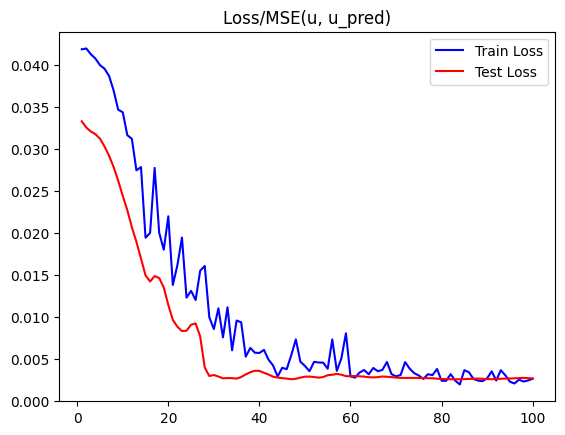

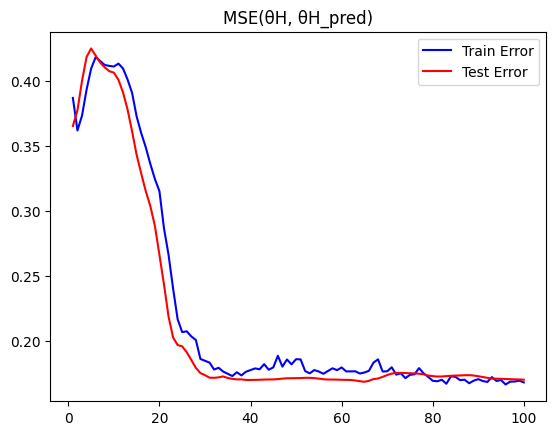

In [46]:
def loss_plot():
    plt.plot(epoch_list, train_losses, color='b', label='Train Loss')
    plt.plot(epoch_list, test_losses, color='r', label='Test Loss')
    plt.title('Loss/MSE(u, u_pred)')
    plt.legend()

def error_plot():
    plt.plot(epoch_list, theta_H_train_errs, color='b', label='Train Error')
    plt.plot(epoch_list, theta_H_test_errs, color='r', label='Test Error')
    plt.title('MSE(θH, θH_pred)')
    plt.legend()

loss_plot()
plt.show()
error_plot()
plt.show()

In [10]:
exp_name = 'varying_mental_varying_physical_large_eps'
exp_settings = {'sim_policy': sim_policy, 'sim_time': sim_time, 'n_demo': n_demo,
                'is_updating_internal_model': is_updating_internal_model,
                'stochastic_human': stochastic_human, 'human_lr': human_lr,
                'train_split': train_split, 'epochs': epochs, 'model_lr': model_lr}

folder_name = 'experiments/{}'.format(exp_name)
# assert not os.path.isdir(folder_name)
os.makedirs(folder_name)

with open(folder_name + '/settings.json', 'w') as f:
    json.dump(exp_settings, f)

loss_plot()
plt.savefig(folder_name + '/loss_plot.png')
plt.clf()
error_plot()
plt.savefig(folder_name + '/error_plot.png')
plt.clf()

<Figure size 640x480 with 0 Axes>

In [ ]:
# RL code similar to Assisted Perception paper
# increase n_demo to get MSE under 0.1 (and try training for more epochs)

### Rollout function reward and environment

In [47]:
import copy
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

rollout_reward_hist = []
def rollout_reward(pi, robot_mode):
    sum_rewards = 0
    NUM_ROLLOUTS = 10
    for _ in range(NUM_ROLLOUTS):
        env = HumanRobotEnv(robot_mode, 1.0, 'use_model_human', True, human_lr)
        env.set_environment(A, B, Q, R, None, None, 20)
        env.set_action_set(None, u_t0_R_aug_set)
        env.set_human_internal_model(None)
        env.set_human_state(np.array([[0.4], [-0.0]]), np.array([[1.0]])) # Q: Should this be made varying?
        obs = env.reset()
        
        for _ in range(env.episode_length):
            if robot_mode == 'active_teaching':
                action, _ = pi.predict(obs, deterministic=True)
            else:
                action = None
            obs, _, done, _ = env.step(action)
            if done:
                break
        sum_rewards += np.sum(env.current_demo_reward_traj)
    sum_rewards /= NUM_ROLLOUTS
    rollout_reward_hist.append(copy.deepcopy(sum_rewards))
    return sum_rewards

def rollout_env(pi, robot_mode):
    env = HumanRobotEnv(robot_mode, 1.0, 'use_model_human', True, human_lr)
    env.set_environment(A, B, Q, R, None, None, 20)
    env.set_action_set(None, u_t0_R_aug_set)
    env.set_human_internal_model(None)
    env.set_human_state(np.array([[0.4], [-0.0]]), np.array([[1.0]])) # Q: Should this be made varying?
    obs = env.reset()

    for i in range(env.episode_length):
        if robot_mode == 'active_teaching':
            action, _ = pi.predict(obs, deterministic=True)
        else:
            action = None
        obs, _, done, _ = env.step(action)
        if done:
            break
    return env

class ModelSaveCallback(BaseCallback):
    def __init__(self, check_freq, log_dir, model_name, robot_action_mode, verbose):
        super(ModelSaveCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, model_name)
        self.best_mean_reward = -np.inf
        self.robot_action_mode = robot_action_mode
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            mean_reward = rollout_reward(self.model, 'active_teaching')
            if self.verbose > 0:
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")
          
            # New best model, you could save the agent here
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                # Example for saving best model
                if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                self.model.save(self.save_path)
        return True

In [48]:
env = HumanRobotEnv('active_teaching', 1.0, 'use_model_human', True, human_lr)
env.set_environment(A, B, Q, R, None, None, 20)
env.set_action_set(None, u_t0_R_aug_set)
env.set_human_internal_model(None)

env.set_human_state(np.array([[0.4], [0.]]), np.array([[1.0]]))
best_pi = None

log_dir = 'active_teaching/'
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
pi_infl = PPO('MlpPolicy', env, verbose=True)
callback = ModelSaveCallback(check_freq=1000, log_dir=log_dir,
                             model_name='active_teaching_easy',
                             robot_action_mode=env.robot_action_mode,
                             verbose=True)
pi_infl.learn(30000, callback=callback)

Using cpu device
Wrapping the env in a DummyVecEnv.
Best mean reward: -inf - Last mean reward per episode: -9.50
Saving new best model to active_teaching/active_teaching_easy.zip
Best mean reward: -9.50 - Last mean reward per episode: -9.50
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | -9.26    |
| time/              |          |
|    fps             | 1071     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
Best mean reward: -9.50 - Last mean reward per episode: -8.87
Saving new best model to active_teaching/active_teaching_easy.zip
Best mean reward: -8.87 - Last mean reward per episode: -8.92
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 19          |
|    ep_rew_mean          | -9.11       |
| time/                   |             |
|    fps           

In [49]:
env_active = rollout_env(pi_infl, 'active_teaching')
env_passive = rollout_env(pi_infl, 'passive_teaching')

print('Passive cumulative rewards:', np.sum(env_passive.current_demo_reward_traj))
print('Active cumulative rewards:', np.sum(env_active.current_demo_reward_traj))

Passive cumulative rewards: -9.256320645329755
Active cumulative rewards: -7.6768737533201925


### Robot reward

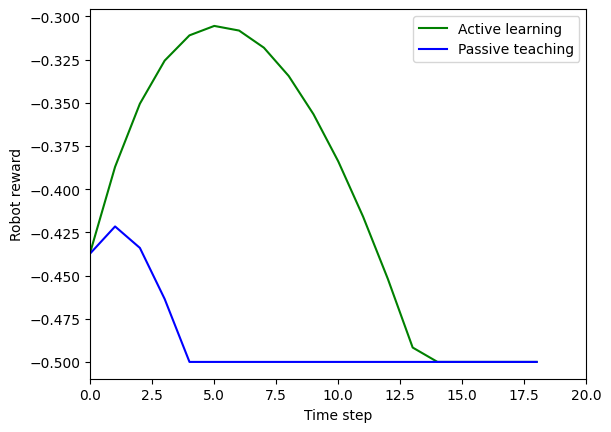

In [50]:
plt.plot(env_active.current_demo_reward_traj,'g',markersize = 3, label='Active learning')
plt.plot(env_passive.current_demo_reward_traj,'b',markersize = 3, label='Passive teaching')
plt.xlim([0, env_passive.episode_length])
#plt.ylim([-0.3,0.05])
plt.xlabel('Time step')
plt.ylabel('Robot reward')
plt.legend(loc="upper right")
plt.show()

### $\theta_H$ error

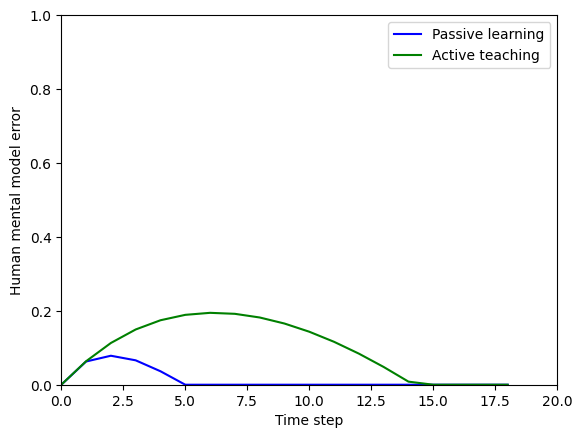

In [55]:
static_human_mental_error_hist = 1.0 - np.array(env_passive.current_demo_human_mental_state_traj)[:,0,0]
dynamic_human_mental_error_hist = 1.0 - np.array(env_active.current_demo_human_mental_state_traj)[:,0,0]
plt.plot( np.abs(static_human_mental_error_hist),'b-',markersize = 3, label='Passive learning')
plt.plot( np.abs(dynamic_human_mental_error_hist),'g-',markersize = 3, label='Active teaching')
plt.xlim([0, env_passive.episode_length])
plt.ylim([0,1])
plt.xlabel('Time step')
plt.ylabel('Human mental model error')
plt.legend(loc="upper right")
plt.show()

### Robot task reward

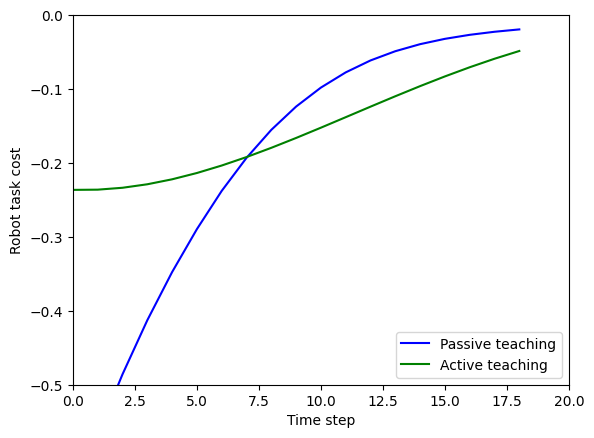

In [52]:
plt.plot(env_passive.current_demo_task_reward_traj,'b-',markersize = 3, label='Passive teaching')
plt.plot(env_active.current_demo_task_reward_traj,'g-',markersize = 3, label='Active teaching')
plt.xlim([0, env_passive.episode_length])
plt.ylim([-0.5,0])
plt.xlabel('Time step')
plt.ylabel('Robot task cost')
plt.legend(loc="lower right")
plt.show()

### Robot action reward

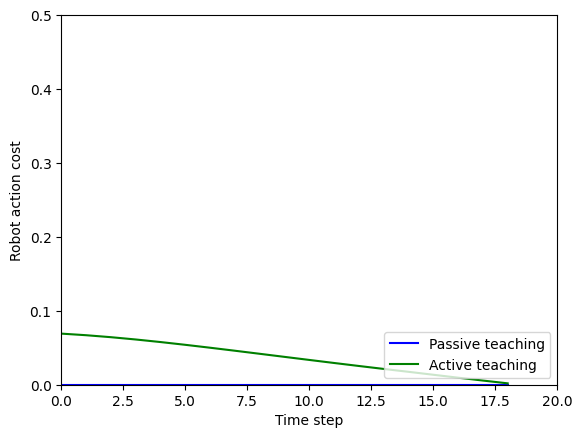

In [53]:
plt.plot(env_passive.current_demo_action_reward_traj,'b-',markersize = 3, label='Passive teaching')
plt.plot(env_active.current_demo_action_reward_traj,'g-',markersize = 3, label='Active teaching')
plt.xlim([0, env_passive.episode_length])
plt.ylim([0 , 0.5])
plt.xlabel('Time step')
plt.ylabel('Robot action cost')
plt.legend(loc="lower right")
plt.show()

### Human optimal action

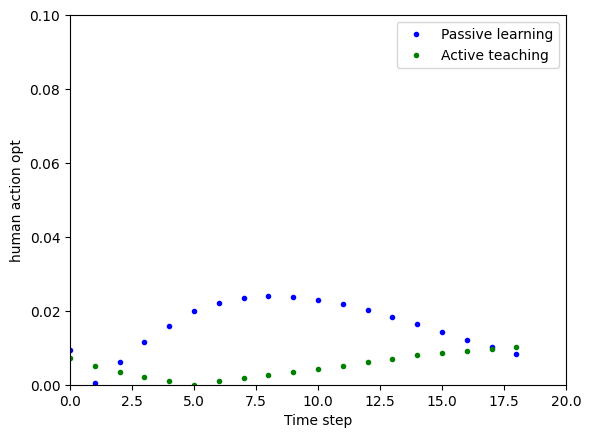

In [54]:
plt.plot(env_passive.current_demo_human_action_opt_traj,'bo',markersize = 3, label='Passive learning')
plt.plot(env_active.current_demo_human_action_opt_traj,'go',markersize = 3, label='Active teaching')
plt.xlim([0, env_passive.episode_length])
plt.ylim([0,0.1])
plt.xlabel('Time step')
plt.ylabel('human action opt')
plt.legend(loc="upper right")
plt.show()